In [ ]:
#將google drive掛載在colob
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd 'gdrive/My Drive/orchid'
!ls

/content/gdrive/My Drive/orchid
label.csv     orchid_private_set.zip  pic   train
orchid.ipynb  orchid_public_set.zip   test


In [ ]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import time
import copy
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.hub import load_state_dict_from_url
import torchvision
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split

import cv2

import matplotlib.pyplot as plt
from PIL import Image

from tqdm.auto import tqdm

from __future__ import print_function, division

In [ ]:
##GPU setting
device = 'cpu'
if torch.cuda.is_available(): # 若想可以使用 cuda
    device = 'cuda'
print(f'Using {device} for training.')
torch.cuda.is_available()

Using cuda for training.


True

In [ ]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=0d15b2683ea9e37956122e5b9380aba23d660e3cd80b329bbb06446f9b403ce8
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


## Unzip


In [ ]:
import zipfile

test_path = '/content/dataset/'
if (os.path.isdir(test_path) == False):
    os.mkdir(test_path)

local_zip = '/content/gdrive/MyDrive/orchid/orchid_public_set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content/dataset/')
zip_ref.close()

### hyperparameter

可以不用理這個參數，這是我用resnet去跑ㄉ參數

In [ ]:
##Hyperparameters
SEED = 42
# data
DATA_PATH = '/content/gdrive/MyDrive/orchid/train/'
BATCH_SIZE = 4
NUM_WORKERS = 2
MEAN, STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) # mean and std for ImageNet

# training
LR = 1e-3  #learning rate
EPOCHS = 10
MOMENTUM = 0.9   #activate(Optimizer) function SGD用到的變數。
WEIGHT_DECAY = 1e-4 #調整loss在一定範圍內
PRINT_FREQ = 10   #training中每處理多少資料顯示一次目前結果。

### Read data

In [ ]:
label = pd.read_csv("label.csv")
#label.shape
label.head(10)

,filename,category
0,me3uqlixjn.jpg,0
1,5c0vsrdtpq.jpg,0
2,swixut5b3l.jpg,0
3,m0eqa926lo.jpg,0
4,5jr6x2y9p8.jpg,0
5,9y7sv8xqc2.jpg,0
6,nzt9hr5se2.jpg,0
7,niky1zwp74.jpg,0
8,3jdlrqgcz4.jpg,0
9,m4dtjfyu0w.jpg,0


In [ ]:
#print(label['category'].unique())

In [ ]:
#print(label.groupby('category').size())

In [ ]:
import glob
dirPathPattern = r"/content/gdrive/MyDrive/orchid/train/*.jpg"
img = glob.glob(dirPathPattern)

all_file = DATA_PATH + label['filename']
#y = label['category']

idx = [] #刪除照片的index
for i in range(0,len(all_file)):
  if all_file[i] not in img:
    print(i)
    idx.append(i)

label.info()
label_name = label['filename']
label_cate = label['category']

#print(label)
#print(idx)
#print(img)

#img = cv2.imread(X[0])
#img = []
#for i in range(0,len(X)):
#  img = cv2.imread(X[i])
#print(img)
#print(X)
#print(y)

96
98
483
884
931
937
975
1068
1598
1616
1617
1619
1924
2042
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2190 non-null   object
 1   category  2190 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.3+ KB


In [ ]:
check_label = label.drop(index=idx, axis=0) #刪完的label data
X = DATA_PATH + check_label['filename']
y = check_label['category']
print(X)
print(y)

label.info()
check_label.info()

#print(X.isnull().values.any())

0       /content/gdrive/MyDrive/orchid/train/me3uqlixj...
1       /content/gdrive/MyDrive/orchid/train/5c0vsrdtp...
2       /content/gdrive/MyDrive/orchid/train/swixut5b3...
3       /content/gdrive/MyDrive/orchid/train/m0eqa926l...
4       /content/gdrive/MyDrive/orchid/train/5jr6x2y9p...
                              ...                        
2185    /content/gdrive/MyDrive/orchid/train/9a4ryif2x...
2186    /content/gdrive/MyDrive/orchid/train/nhs2oz6q7...
2187    /content/gdrive/MyDrive/orchid/train/atvix0fwn...
2188    /content/gdrive/MyDrive/orchid/train/wpd8temlg...
2189    /content/gdrive/MyDrive/orchid/train/vne5f9kld...
Name: filename, Length: 2176, dtype: object
0         0
1         0
2         0
3         0
4         0
       ... 
2185    218
2186    218
2187    218
2188    218
2189    218
Name: category, Length: 2176, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 

In [ ]:
imgDir = DATA_PATH + check_label['filename']

pic = check_label['filename'] #有刪過的(目前使用的)
cate = check_label['category']
name = {x.replace('.jpg', '') for x in pic}

print(pic.isnull().any())
print(cate.isnull().any())
print(label_name.isnull().any())
print(label_cate.isnull().any())
#print(fullname)
#print(name)
#print(pic)
#print(label)

False
False
False
False


In [ ]:
trainPath = '/content/gdrive/MyDrive/orchid/pic/train/'
validPath = '/content/gdrive/MyDrive/orchid/pic/val/'

if (os.path.isdir(trainPath) == False):
  for i in range(0,218):
    os.mkdir(trainPath + str(i))

if (os.path.isdir(validPath) == False):
  for i in range(0,218):
    os.mkdir(validPath + str(i))

In [ ]:
for i in range(0,len(imgDir)):
  if i in idx:
    continue    
    #index = findLabel(label, fullname(1, i));
  else:
    for j in range(0,len(label)):
      if pic[i] == label_name[j]:
        num = label_cate[j]
        break
    
    #savePathClass = savePath + str(num)
    img = Image.open(imgDir[i])
    img_90 = img.rotate(90)
    img_180 = img.rotate(180)
    img_270 = img.rotate(270)
    img_30 = img.rotate(30)
    img_45 = img.rotate(45)
    img_60 = img.rotate(60)
    img_pad = cv2.copyMakeBorder(np.float32(img), 30, 30, 30, 30, cv2.BORDER_REPLICATE)

    #split into train & valid
    img_list = [img, img_90, img_180, img_270, img_30, img_45, img_60, img_pad]
    val = random.sample(img_list,2)
    tra = []
    for r in range(0,len(img_list)):
      if img_list[r] not in val: #tra
        tra.append(img_list[r])
        os.chdir(trainPath + str(num))
        cv2.imwrite(list(name)[i]+'_'+ str(r) +'.jpg',np.float32(img_list[r]))
      else:
        os.chdir(validPath + str(num))
        cv2.imwrite(list(name)[i]+'_'+ str(r) +'.jpg',np.float32(img_list[r]))
    #print(len(val)) #2
    #print(len(tra)) #6
        
    #os.chdir(savePathClass)
    #cv2.imwrite(pic[i],np.float32(img))
    #cv2.imwrite(list(name)[i]+'_1.jpg',np.float32(img_90))
    #cv2.imwrite(list(name)[i]+'_2.jpg',np.float32(img_180))
    #cv2.imwrite(list(name)[i]+'_3.jpg', np.float32(img_270))
    #cv2.imwrite(list(name)[i]+'_4.jpg', np.float32(img_30))
    #cv2.imwrite(list(name)[i]+'_5.jpg', np.float32(img_60))
    #cv2.imwrite(list(name)[i]+'_6.jpg', np.float32(img_pad))
    print( str(i) +' Done')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


0 Done
1 Done
2 Done
3 Done
4 Done
5 Done
6 Done
7 Done
8 Done
9 Done
10 Done
11 Done
12 Done
13 Done
14 Done
15 Done
16 Done
17 Done
18 Done
19 Done
20 Done
21 Done
22 Done
23 Done
24 Done
25 Done
26 Done
27 Done
28 Done
29 Done
30 Done
31 Done
32 Done
33 Done
34 Done
35 Done
36 Done
37 Done
38 Done
39 Done
40 Done
41 Done
42 Done
43 Done
44 Done
45 Done
46 Done
47 Done
48 Done
49 Done
50 Done
51 Done
52 Done
53 Done
54 Done
55 Done
56 Done
57 Done
58 Done
59 Done
60 Done
61 Done
62 Done
63 Done
64 Done
65 Done
66 Done
67 Done
68 Done
69 Done
70 Done
71 Done
72 Done
73 Done
74 Done
75 Done
76 Done
77 Done
78 Done
79 Done
80 Done
81 Done
82 Done
83 Done
84 Done
85 Done
86 Done
87 Done
88 Done
89 Done
90 Done
91 Done
92 Done
93 Done
94 Done
95 Done
97 Done
99 Done
100 Done
101 Done
102 Done
103 Done
104 Done
105 Done
106 Done
107 Done
108 Done
109 Done
110 Done
111 Done
112 Done
113 Done
114 Done
115 Done
116 Done
117 Done
118 Done
119 Done
120 Done
121 Done
122 Done
123 Done
124 Done
1

### transform

In [ ]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((224,224)),
            ########在此區塊填入圖像轉換方法########
            #transforms.RandomHorizontalFlip(),
            #transforms.RandomVerticalFlip(),
            #transforms.RandomRotation((-30,30)),
            #transforms.Grayscale(num_output_channels=3),
            #transforms.Pad(30, padding_mode="edge"),
            ########################################
            transforms.ToTensor(),
        ]),
        'val': transforms.Compose([
            transforms.Resize((224,224) ),
            transforms.ToTensor(),
        ]),
    }

### Model

In [ ]:
class MyCNN(nn.Module):

  def __init__(self, num_classes):
    super(MyCNN, self).__init__()
    self.features = nn.Sequential(
      #============== 在此區塊新增或減少隱藏層 =================
      nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
      

      nn.Conv2d(64, 192, kernel_size=5, padding=2),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
      

      nn.Conv2d(192, 384, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),

      nn.Conv2d(384, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),

      nn.Conv2d(256, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
      #==========================================================
    )
    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
    self.classifier = nn.Sequential(
      nn.Dropout(),
      nn.Linear(256 * 6 * 6, 4096),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      nn.Linear(4096, 4096),
      nn.ReLU(inplace=True),
      # nn.Linear(4096, num_classes), # 原始模型輸出層
    )

    self.myLinear = nn.Linear(4096, num_classes)


  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)

    x = self.myLinear(x)

    return x

In [ ]:
def visualize_model(model, device, dataloaders, class_names, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0

  plt.figure(figsize=(18,9))

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1

        img_display = np.transpose(inputs.cpu().data[j].numpy(), (1,2,0)) #numpy:CHW, PIL:HWC
        plt.subplot(num_images//2,2,images_so_far),plt.imshow(img_display) #nrow,ncol,image_idx
        plt.title(f'predicted: {class_names[preds[j]]}')
        plt.savefig("test.jpg")
        if images_so_far == num_images:
            model.train(mode=was_training)
            return
    model.train(mode=was_training)

def imshow(inp, title=None):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  
  #原先Normalize是對每個channel個別做 減去mean, 再除上std
  inp1 = std * inp + mean

  plt.imshow(inp)

  if title is not None:
      plt.title(title)
  plt.pause(0.001)  # pause a bit so that plots are updated
  plt.imshow(inp1)
  if title is not None:
      plt.title(title)


def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

# train

In [ ]:
def train_model(model, criterion, device, dataloaders, dataset_sizes, optimizer, scheduler, num_epochs):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  train_loss, valid_loss = [], []
  train_acc, valid_acc = [], []

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in tqdm(dataloaders[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            if phase == 'train':
                # zero the parameter gradients
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      if phase == 'train':
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
      else:
        valid_loss.append(epoch_loss)
        valid_acc.append(epoch_acc)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())


  plt.figure(0)
  plt.plot(range(1,num_epochs+1,1), np.array(train_loss), 'r-', label= "train loss") #relative global step
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.savefig(f"./train_loss.png")

  plt.figure(1)
  plt.plot(range(1,num_epochs+1,1), np.array(valid_loss), 'b-', label= "eval loss") #--evaluate_during_training True 在啟用eval
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.savefig(f"./eval_loss.png")

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  #torch.save(model.state_dict(),"model.pt")
  return model

# test

In [ ]:
def test(model, loader, criterion):
    """This function tests the model on the test set."""
    # recorders
    loss_m = AverageMeter()
    out_list, y_list = [], []
    
    model.eval() # set model to eval mode
    
    with torch.no_grad(): # no need to compute gradient when testing
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            # model forward
            outputs = model(imgs)
            
            # compute loss
            loss = criterion(outputs, labels)
            
            y_list.append(labels)
            out_list.append(outputs)
            loss_m.update(loss.item())
        
        # concat all predictions and answers to compute accuracy
        pred = torch.cat(out_list)
        y = torch.cat(y_list)
        acc = accuracy(pred, y)   
        
    return loss_m.avg, acc.item()

# Start 

In [ ]:
num_epochs = 30
lr = 1e-3
batch_size = 64

Using device cuda:0



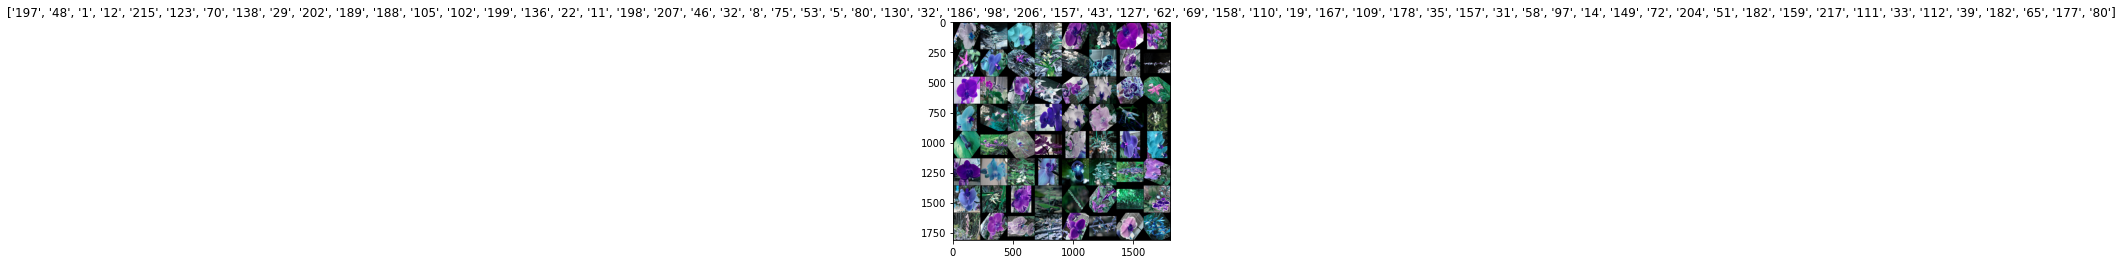

features.0.weight
features.0.bias
features.3.weight
features.3.bias
features.6.weight
features.6.bias
features.8.weight
features.8.bias
features.10.weight
features.10.bias
classifier.1.weight
classifier.1.bias
classifier.4.weight
classifier.4.bias
myLinear.weight
myLinear.bias
#parameters:57901083
batch_size:64
Epoch 1/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 2.1299 Acc: 0.4870


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.5593 Acc: 0.8269
Epoch 2/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.4203 Acc: 0.8690


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.1970 Acc: 0.9439
Epoch 3/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.1737 Acc: 0.9466


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0703 Acc: 0.9794
Epoch 4/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0961 Acc: 0.9702


  0%|          | 0/136 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1e95e9e60>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1e95e9e60>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/lib/pytho

val Loss: 0.0384 Acc: 0.9895
Epoch 5/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0706 Acc: 0.9784


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0339 Acc: 0.9906
Epoch 6/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0500 Acc: 0.9848


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0384 Acc: 0.9902
Epoch 7/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0463 Acc: 0.9866


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0229 Acc: 0.9950
Epoch 8/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0119 Acc: 0.9967


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0105 Acc: 0.9985
Epoch 9/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0071 Acc: 0.9986


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0103 Acc: 0.9985
Epoch 10/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0072 Acc: 0.9981


  0%|          | 0/136 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1e95e9e60>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1e95e9e60>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

val Loss: 0.0096 Acc: 0.9985
Epoch 11/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0057 Acc: 0.9985


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0099 Acc: 0.9985
Epoch 12/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0056 Acc: 0.9987


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0098 Acc: 0.9987
Epoch 13/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0055 Acc: 0.9988


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0097 Acc: 0.9987
Epoch 14/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0042 Acc: 0.9992


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0097 Acc: 0.9985
Epoch 15/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0042 Acc: 0.9992


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0095 Acc: 0.9985
Epoch 16/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0044 Acc: 0.9992


  0%|          | 0/136 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1e95e9e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1e95e9e60>
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1e95e9e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3

val Loss: 0.0094 Acc: 0.9987
Epoch 17/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0043 Acc: 0.9991


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1e95e9e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


  0%|          | 0/136 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1e95e9e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


val Loss: 0.0094 Acc: 0.9990
Epoch 18/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0037 Acc: 0.9993


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0094 Acc: 0.9990
Epoch 19/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0037 Acc: 0.9995


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0094 Acc: 0.9987
Epoch 20/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0039 Acc: 0.9993


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0094 Acc: 0.9987
Epoch 21/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0047 Acc: 0.9989


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0094 Acc: 0.9987
Epoch 22/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0038 Acc: 0.9994


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0094 Acc: 0.9987
Epoch 23/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1e95e9e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1e95e9e60>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1e95e9e60>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3

train Loss: 0.0035 Acc: 0.9994


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0094 Acc: 0.9987
Epoch 24/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0040 Acc: 0.9991


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1e95e9e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


  0%|          | 0/136 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1e95e9e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


val Loss: 0.0094 Acc: 0.9987
Epoch 25/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0043 Acc: 0.9989


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0094 Acc: 0.9987
Epoch 26/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0044 Acc: 0.9988


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0094 Acc: 0.9987
Epoch 27/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0043 Acc: 0.9991


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0094 Acc: 0.9990
Epoch 28/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0044 Acc: 0.9990


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0094 Acc: 0.9990
Epoch 29/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0037 Acc: 0.9993


  0%|          | 0/136 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1e95e9e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1e95e9e60>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

val Loss: 0.0094 Acc: 0.9990
Epoch 30/30
----------


  0%|          | 0/405 [00:00<?, ?it/s]

train Loss: 0.0042 Acc: 0.9991


  0%|          | 0/136 [00:00<?, ?it/s]

val Loss: 0.0094 Acc: 0.9990
Training complete in 144m 5s
Best val Acc: 0.998959


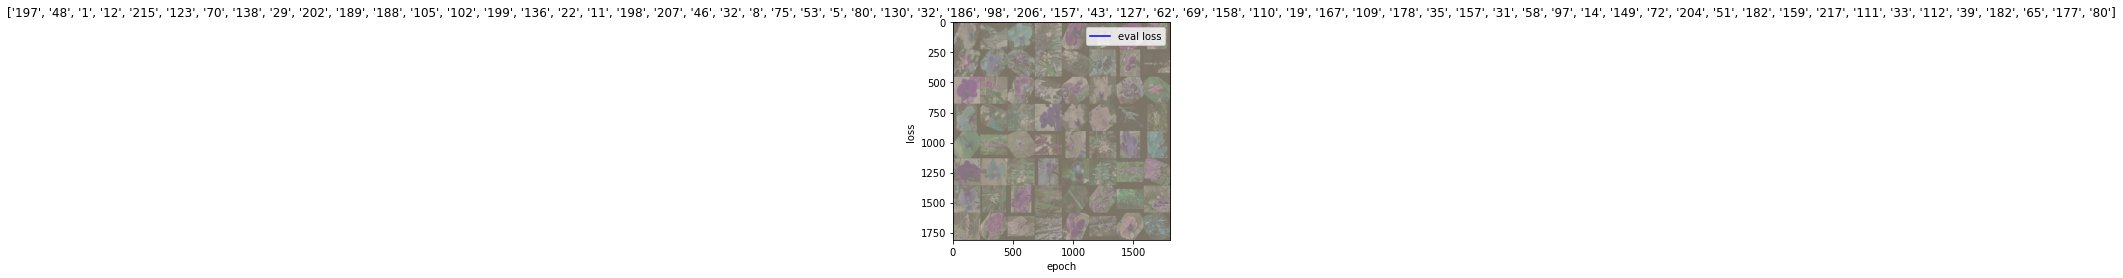

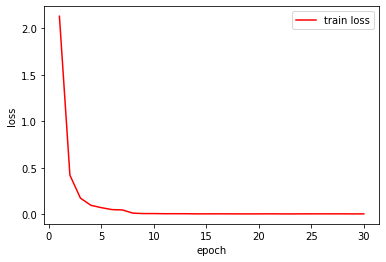

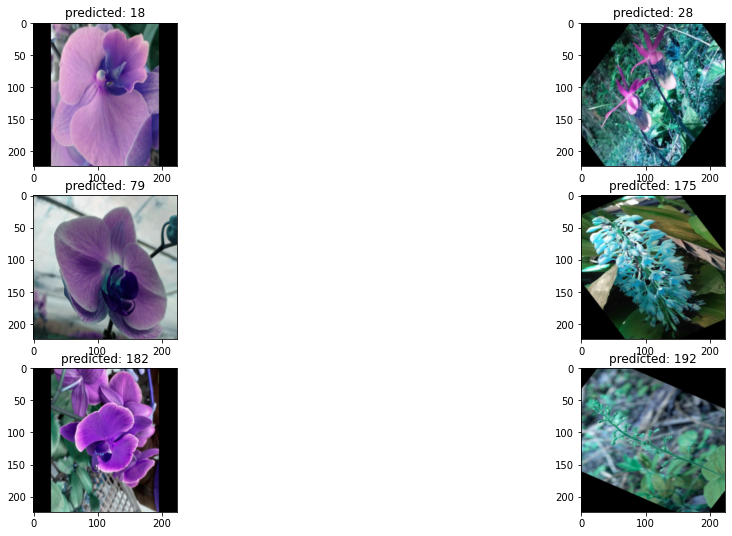

In [ ]:
def main():
  num_workers = 2
  momentum = 0.9

  # 資料集載入 =======================================================================
  data_dir = '/content/gdrive/MyDrive/orchid/pic/'
  image_datasets = {
    x: datasets.ImageFolder(
      os.path.join(data_dir, x),
      data_transforms[x]
    ) 
    for x in ['train', 'val']
  }
  dataloaders = {
    x: torch.utils.data.DataLoader(
      image_datasets[x], 
      batch_size=batch_size,
      shuffle=True, 
      num_workers=num_workers
    )
    for x in ['train', 'val']
  }
  dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
  class_names = image_datasets['train'].classes
  # 資料集載入 =======================================================================

  # 設定 CUDA 環境 =======================================================================
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Using device {device}\n")
  # 設定 CUDA 環境 =======================================================================


  # Get a batch of training data
  inputs, classes = next(iter(dataloaders['train']))

  # Make a grid from batch
  out = torchvision.utils.make_grid(inputs)

  imshow(out, title=[class_names[x] for x in classes])

  
  # model =======================================================================
  model_ft = MyCNN(num_classes=219)
  #model_ft = ExampleCNN()
  pretrained_dict = load_state_dict_from_url(
    'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
    progress=True
  )
  model_dict = model_ft.state_dict()
  # 1. filter out unnecessary keys
  pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
  # 2. overwrite entries in the existing state dict
  model_dict.update(pretrained_dict) 
  # 3. load the new state dict
  model_ft.load_state_dict(model_dict)

  for k,v in model_dict.items():
    print(k)

  model_ft = model_ft.to(device)
  # model =======================================================================

  parameter_count = count_parameters(model_ft)
  print(f"#parameters:{parameter_count}")
  print(f"batch_size:{batch_size}")


  criterion = nn.CrossEntropyLoss()

  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

  model_ft = train_model(
    model_ft, 
    criterion, 
    device, 
    dataloaders, 
    dataset_sizes, 
    optimizer_ft, 
    exp_lr_scheduler,     
    num_epochs=num_epochs
  )

  visualize_model(model_ft, device, dataloaders, class_names)

if __name__ == '__main__':
    main()

## Transformer 

In [ ]:
##Transformer
"""""
normalize = transforms.Normalize(mean=MEAN, std=STD)
# a set of common trasnformation combination for training
train_transforms = transforms.Compose([
  transforms.Resize(256),
  transforms.RandomResizedCrop(224),
  transforms.ToTensor(),
  normalize
])


# transformations for testing do not need to do fancy tricks
test_transforms = transforms.Compose([
  transforms.Resize(256),
  transforms.RandomResizedCrop(224), #依據給定的size從中心裁剪參數
  transforms.ToTensor(),
  normalize
])
"""""